# Project: Predict Future Sales
#### Notebook 1 of 4: Data Cleaning and EDA

In this notebook, we mainly did the following:
- Import data:
    - "items_en.csv"
    - "shops_en.csv"
    - "item_categories_en.csv"
    - "sales_train.csv"
    - "test.csv"
    
- Data Cleaning:
    - check and handle outliers
    - check and handle null values
    
- EDA and found:
    - many shops seemed closed after running some months
    - stable monthly sales in some shops
    - downtrend monthly sales in many shops
    - uptrend monthly sales in 2 online shops
    - not all shops in test data
    - shop_id: 0 and 57 seem of the same shop
    - shop_id: 1 and 58 seem of the same shop
    - shop_id: 10 and 11 seem of the same shop
    - Different trends occur in different categories.
    - Seasonality are observed in some categories
    - Many categories are no longer for sale, which will be not considered in modelling
    - not every category was available in every shop
    - the sales of each category varid dramatically


- We also built a grid from all shops/items combinations from each month
    - all our coming modelling is based on this grid 

    
    

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns



import matplotlib
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from textwrap import wrap

pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', None)

import pickle
import time
import datetime

from itertools import product


# define functions

In [118]:
#import data and do basic EDA
def import_data(path):
    df = pd.read_csv(path)
    
    print("printing dataframe shape")
    print(df.shape)
    
    print("\n\nprinting dataframe info")
    df.info()
    
    print("\n\nprinting first 5 rows")
    print(df.head())
    
    print("\n\nprinting descriptive statistics")
    print(df.describe())
    
    print("\n\nprinting null value summary")
    print(df.isnull().sum())
    return df

In [119]:
#https://github.com/matthiasanderer/m5-accuracy-competition/blob/main/m5-simple-fe-evaluation.ipynb

## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Data Import and basic clean

### df_items

In [120]:
path = "../datasets/items_en.csv"
df_items = import_data(path)

printing dataframe shape
(22170, 3)


printing dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


printing first 5 rows
                                                     item_name  item_id  \
0                          ! IN THE POWER OF GLAMOR (PLAST.) D        0   
1  !ABBYY FineReader 12 Professional Edition Full [PC Digital]        1   
2                             *** IN THE RAYS OF GLORY (UNV) D        2   
3                                        ***BLUE WAVE (Univ) D        3   
4                                             ***BOX (GLASS) D        4   

   item_category_id  
0                40  
1                76  
2      

### df_shops

In [122]:
path = "../datasets/shops_en.csv"
df_shops = import_data(path)

printing dataframe shape
(60, 2)


printing dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


printing first 5 rows
                                  shop_name  shop_id
0         !Yakutsk Ordzhonikidze, 56 francs        0
1  !Yakutsk shopping center "Central" franc        1
2             Adygea shopping center "Mega"        2
3          Balashikha SEC "October-Kinomir"        3
4     Volzhsky shopping center "Volga Mall"        4


printing descriptive statistics
       shop_id
count    60.00
mean     29.50
std      17.46
min       0.00
25%      14.75
50%      29.50
75%      44.25
max      59.00


printing null value summary
shop_name    0
shop_id      0
dtype: int64



### df_cat

In [124]:
path = "../datasets/item_categories_en.csv"
df_cat = import_data(path)

printing dataframe shape
(84, 2)


printing dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


printing first 5 rows
         item_category_name  item_category_id
0  PC - Headsets/Headphones                 0
1         Accessories - PS2                 1
2         Accessories - PS3                 2
3         Accessories - PS4                 3
4         Accessories - PSP                 4


printing descriptive statistics
       item_category_id
count             84.00
mean              41.50
std               24.39
min                0.00
25%               20.75
50%               41.50
75%               62.25
max               83.00


printing null value summary
item_category_nam

In [126]:
cat_item_list=df_items.groupby('item_category_id')['item_id'].unique().tolist()
df_cat['unique_item_num']=[len(cat_item_list[i].tolist()) for i in range(len(cat_item_list))]

### df_train

In [128]:
path = "../datasets/sales_train.csv"
df_train = import_data(path)

printing dataframe shape
(2935849, 6)


printing dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


printing first 5 rows
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00          1.00
1  03.01.2013               0       25     2552      899.00          1.00
2  05.01.2013               0       25     2552      899.00         -1.00
3  06.01.2013               0       25     2554    1,709.05          1.00
4  15.01.2013               0       25     2555    1,099.00          1.00


printing descriptive statistics
       date_block_num     

In [129]:
#action
df_train['date']=pd.to_datetime(df_train['date'],format="%d.%m.%Y")
#df_train['year_month'] = df_train['date'].dt.to_period('M')
#df_train['month'] = df_train['date'].dt.month
#df_train = df_train.drop(columns=['date'])

In [133]:
# merge df_train and df_items
df_train = df_train.merge(df_items, left_on='item_id', right_on='item_id', how='left' )
df_train = df_train.drop(columns=['item_name'])
print(df_train.shape)
df_train.head()

(2935849, 7)

### df_test

In [136]:
path = "../datasets/test.csv"
df_test = import_data(path)

printing dataframe shape
(214200, 3)


printing dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


printing first 5 rows
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


printing descriptive statistics
              ID    shop_id    item_id
count 214,200.00 214,200.00 214,200.00
mean  107,099.50      31.64  11,019.40
std    61,834.36      17.56   6,252.64
min         0.00       2.00      30.00
25%    53,549.75      16.00   5,381.50
50%   107,099.50      34.50  11,203.00
75%   160,649.25      47.00  16,071.50
max   214,199.00      59.00  22,167.00


printing null value summary
ID         0
shop_id 

In [137]:
#action
#df_test['date'] = datetime.date(2015, 11, 30)
#df_test['date']=pd.to_datetime(df_test['date'])
#df_test['year_month'] = df_test['date'].dt.to_period('M')
#df_test['month'] = df_test['date'].dt.month
df_test['date_block_num'] = 34
#df_test = df_test.drop(columns=['date'])

In [138]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   ID              214200 non-null  int64
 1   shop_id         214200 non-null  int64
 2   item_id         214200 non-null  int64
 3   date_block_num  214200 non-null  int64
dtypes: int64(4)
memory usage: 6.5 MB


In [140]:
# merge df_test and df_items
df_test = df_test.merge(df_items, left_on='item_id', right_on='item_id', how='left' )
df_test = df_test.set_index('ID',drop=False)
df_test = df_test.drop(columns=['item_name'])
df_test.shape

(214200, 5)

In [141]:
# produce lists of shops, items and item_categories in df_test for future filtering
test_shop_list = sorted(df_test['shop_id'].unique().tolist())
#print(test_shop_list)
test_item_list = sorted(df_test['item_id'].unique().tolist())
#print(test_item_list)
test_cat_list = sorted(df_test['item_category_id'].unique().tolist())
print(test_cat_list)

[0, 2, 3, 5, 6, 7, 9, 11, 12, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 47, 49, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83]


# EDA and further data clean

### df_train

In [142]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   date_block_num    int64         
 2   shop_id           int64         
 3   item_id           int64         
 4   item_price        float64       
 5   item_cnt_day      float64       
 6   item_category_id  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 179.2 MB


### handle outliers


**'item_price'**

<AxesSubplot: xlabel='item_price'>

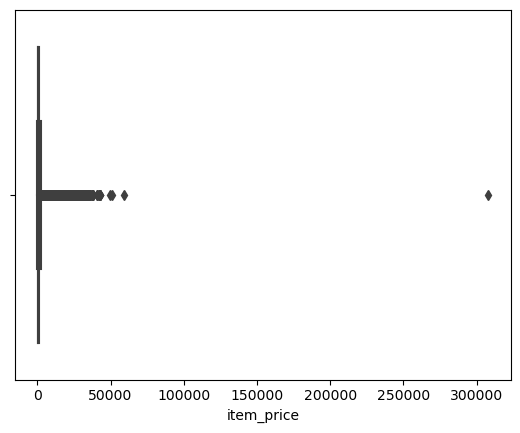

In [145]:
sns.boxplot(data=df_train, x="item_price")

In [146]:
df_train.query("item_price > 100_000 | item_price < 0")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
484683,2013-05-15,4,32,2973,-1.00,1.00,19
1163158,2013-12-13,11,12,6066,"307,980.00",1.00,75


In [147]:
df_train.query("item_id==6066 | item_id== 2973")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
352,2013-01-15,0,25,2973,"2,499.00",13.00,19
353,2013-01-16,0,25,2973,"2,499.00",5.00,19
354,2013-01-17,0,25,2973,"2,499.00",3.00,19
355,2013-01-18,0,25,2973,"2,499.00",2.00,19
356,2013-01-19,0,25,2973,"2,499.00",3.00,19
357,2013-01-20,0,25,2973,"2,499.00",1.00,19
358,2013-01-21,0,25,2973,"2,499.00",1.00,19
359,2013-01-22,0,25,2973,"2,499.00",2.00,19
360,2013-01-24,0,25,2973,"2,499.00",2.00,19
361,2013-01-25,0,25,2973,"2,499.00",2.00,19


In [148]:
#action
#impute the negative price with the price with same item_id from other records
df_train.at[484683,'item_price']=2499
df_train.iloc[484683,:]

date                2013-05-15 00:00:00
date_block_num                        4
shop_id                              32
item_id                            2973
item_price                     2,499.00
item_cnt_day                       1.00
item_category_id                     19
Name: 484683, dtype: object

In [149]:
print("the item_id 6066 seems abnormal, to be deteted")

the item_id 6066 seems abnormal, to be deteted


**'item_cnt_day'**

<AxesSubplot: xlabel='item_cnt_day'>

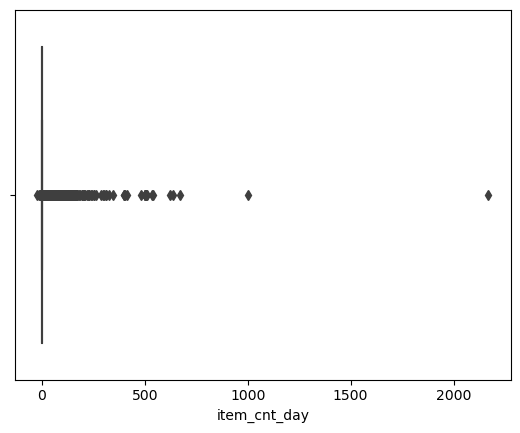

In [150]:
sns.boxplot(data=df_train, x="item_cnt_day")

In [151]:
df_train.query("item_cnt_day > 900")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
2326930,2015-01-15,24,12,20949,4.00,"1,000.00",71
2909818,2015-10-28,33,12,11373,0.91,"2,169.00",9


In [152]:
df_items.query("item_id==20949 | item_id==11373 ")

,item_name,item_id,item_category_id
11373,Delivery to the point of issue (Boxberry),11373,9
20949,Corporate package T-shirt 1C Interest white (34*42) 45 microns,20949,71


In [153]:
print("both records above might be of some events or promotions. they might impact our model,  we just delete these first")

both records above might be of some events or promotions. they might impact our model,  we just delete these first


In [154]:
#action
#to be used in pre-process
index_to_delete=[1163158,2326930,2909818]
df_train = df_train.drop(index_to_delete)

****************************************************

### Our task is to predict monthly sales of each item in each shop. First of all we need to build the monthly training data set from daily data set

In [217]:
agg_dict={'date':'first',
          #'month':'last',
           #'date_block_num':'first',
           #'shop_id':'first',
           #'item_id':'first',
           'item_price': 'mean',
           'item_cnt_day': "sum"
           
          }
df_train_m = df_train.groupby(['date_block_num','shop_id', 'item_category_id','item_id']).agg(agg_dict)
#df_train_m = df_train_m.drop(columns=['date'])
df_train_m.reset_index(inplace=True)
df_train_m.head()

,date_block_num,shop_id,item_category_id,item_id,date,item_price,item_cnt_day
0,0,0,2,5572,2013-01-04,"1,322.00",10.00
1,0,0,2,5573,2013-01-12,560.00,1.00
2,0,0,2,5575,2013-01-06,806.00,4.00
3,0,0,2,5576,2013-01-28,"2,231.00",5.00
4,0,0,2,5609,2013-01-08,"2,381.00",1.00


### concate df_train_m and df_test into df_all

In [160]:
#action

#merge df_train and df_test
df_all = pd.concat([df_train_m,df_test], axis=0, ignore_index=True)

#change column name
df_all.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)

#drop column 'ID'
df_all.drop(columns=['ID','date'],inplace = True)

#fill null value, and convert datatype
#df_all['test_ID'] = df_all['test_ID'].fillna(-1).astype(int)
df_all['item_cnt_month'] = df_all['item_cnt_month'].fillna(0).astype(int)


#fill null values of 'item_price' with last valid price of the same item
df_all = pd.concat([
                    df_all['item_id'],
                    df_all.groupby(['item_id']).fillna(method='ffill')
                    ], axis=1)

df_all.isnull().sum()

item_id                 0
date_block_num          0
shop_id                 0
item_category_id        0
item_price          15246
item_cnt_month          0
dtype: int64

In [161]:
print(df_all[df_all['item_price'].isnull()==True]['date_block_num'].unique())

[34]


In [162]:
print("there are some new arrival items that have no sold record, thus no item_price")

there are some new arrival items that have no sold record, thus no item_price


In [163]:
#action: handle new arrival items
new_arrival_item_list = df_all[df_all['item_price'].isnull()==True]['item_id'].unique()
print("printing new arrival item list:")
print(len(new_arrival_item_list))
print(new_arrival_item_list)


new_arrival_cat_list = df_all[df_all['item_price'].isnull()==True]['item_category_id'].unique()
print('printing categories containing new arrival items')
print(len(new_arrival_cat_list))
print(new_arrival_cat_list)


#create new column to reflect the new arrvial items, which don't have price
df_all["is_new_arrival"] = np.where(df_all['item_id'].isin(new_arrival_item_list), 1, 0)

## set the new arrvial price as 0 first, indicating price not available
df_all['item_price'] = df_all['item_price'].fillna(0)

printing new arrival item list:
363
[ 5320  5268  5826  3538  3571  3604  3407  3408  3405  3984  8551  8822
  8823  8824  8890 10779  9767  8355  8354  6729  6731  6732  6152  6153
  6742  7782  7862  6743  6335 13559 13804 13402 14647 14832 14959  2327
  1732  2322  2323  2326  2569  2966 21467 20400 20401 20836  1580  1585
  1246  1437  2328  2427  2325  3022  1193  1252  1386  1884  1885  1577
  3627  4412  3271  3349 13558 13310 13338 12890 13805 13309 12568 13275
 13251 13303 13250 13249 13232 13242 14648 19773 18913 21397 21708 16051
 16141 16193 15553  1284  5269  6730  3338  4060 11974  7728  7729  7926
  8549  8826  5812  5025  9972 11762  7669 13263 13264  8993  7727 18174
 19219  6863 12117 13209 13273 14521  7592  7607  7646  6903  8545  5322
  4156  5843 11385 13271 10028 10203 16139 22022  3760  3908   640   639
   140   249   428 10507 10045 12469 14784 15665 13745 12802 12961  5844
  6996  7730  8191  6734 20403 20560 20378 20878 16976 19155 21828  1864
 20680  3282  3

In [164]:
df_all.isnull().sum()

item_id             0
date_block_num      0
shop_id             0
item_category_id    0
item_price          0
item_cnt_month      0
is_new_arrival      0
dtype: int64

In [165]:
df_all.describe()

,item_id,date_block_num,shop_id,item_category_id,item_price,item_cnt_month,is_new_arrival
count,"1,823,322.00","1,823,322.00","1,823,322.00","1,823,322.00","1,823,322.00","1,823,322.00","1,823,322.00"
mean,"10,720.74",16.94,32.67,42.10,806.99,2.00,0.01
std,"6,241.45",10.91,16.66,16.44,"1,587.08",7.95,0.09
min,0.00,0.00,0.00,0.00,0.00,-22.00,0.00
25%,"5,070.00",7.00,20.00,30.00,199.00,1.00,0.00
50%,"10,591.00",16.00,31.00,40.00,399.00,1.00,0.00
75%,"16,063.00",26.00,47.00,55.00,899.00,2.00,0.00
max,"22,169.00",34.00,59.00,83.00,"50,999.00","1,644.00",1.00


In [166]:
df_all[df_all['item_cnt_month']<0].sample(10)

,item_id,date_block_num,shop_id,item_category_id,item_price,item_cnt_month,is_new_arrival
324768,10229,5,31,62,"2,199.00",-1,0
192220,17588,3,12,30,249.00,-1,0
266194,15711,4,30,37,499.00,-1,0
1325589,7880,25,37,6,549.00,-1,0
100897,6664,1,32,14,"14,000.00",-1,0
1142921,10957,21,53,37,199.00,-1,0
984096,7797,18,18,23,"4,899.00",-1,0
1349319,3344,26,15,24,"2,999.00",-1,0
523847,20648,9,7,72,"1,199.00",-1,0
188148,18978,3,4,40,149.00,-1,0


### plot monthly sales for each shop

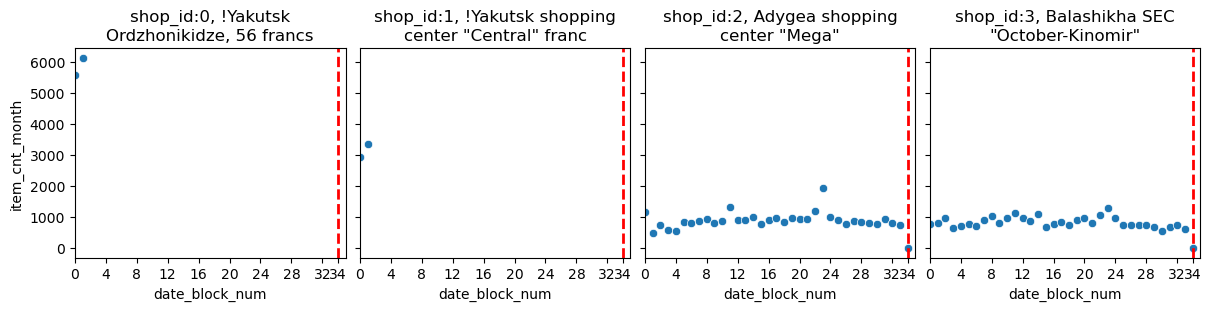

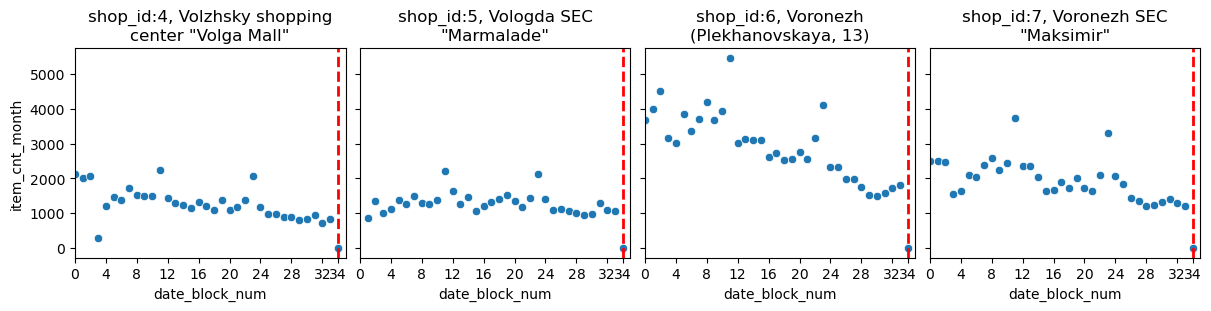

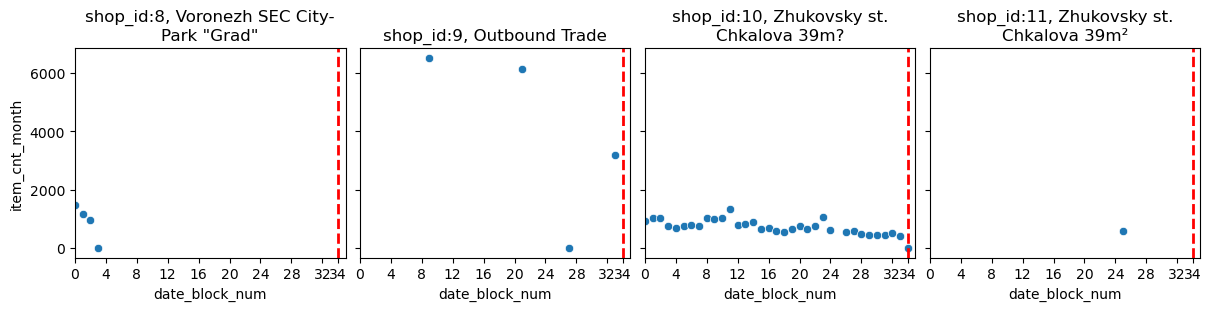

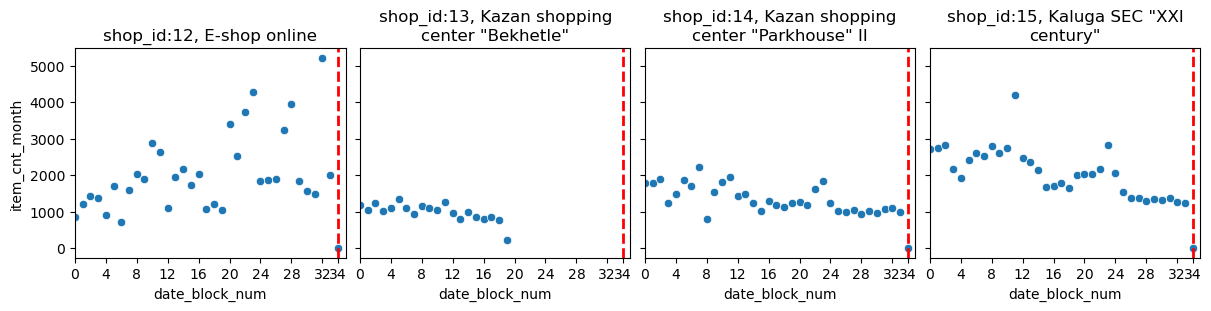

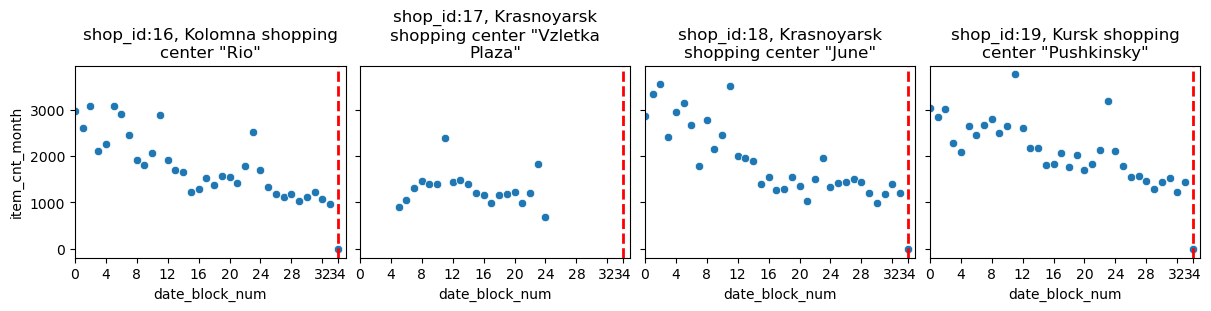

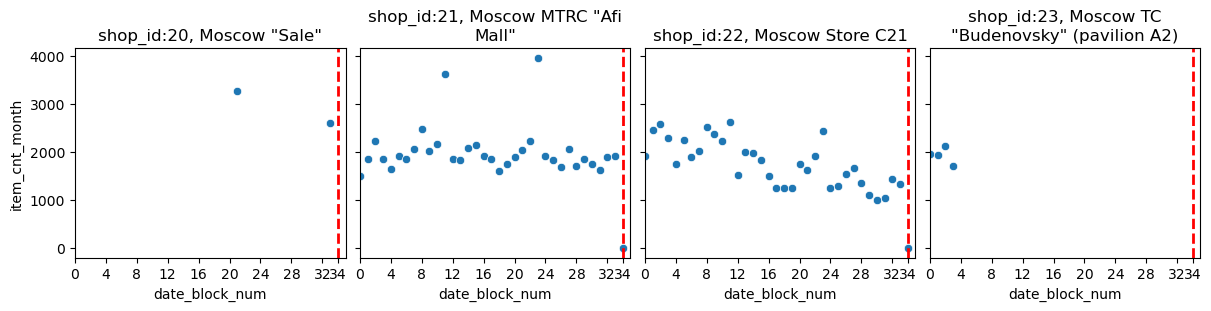

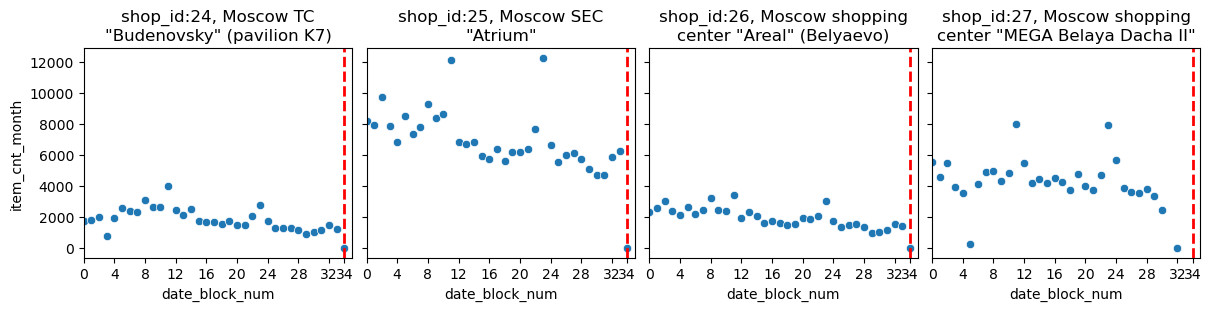

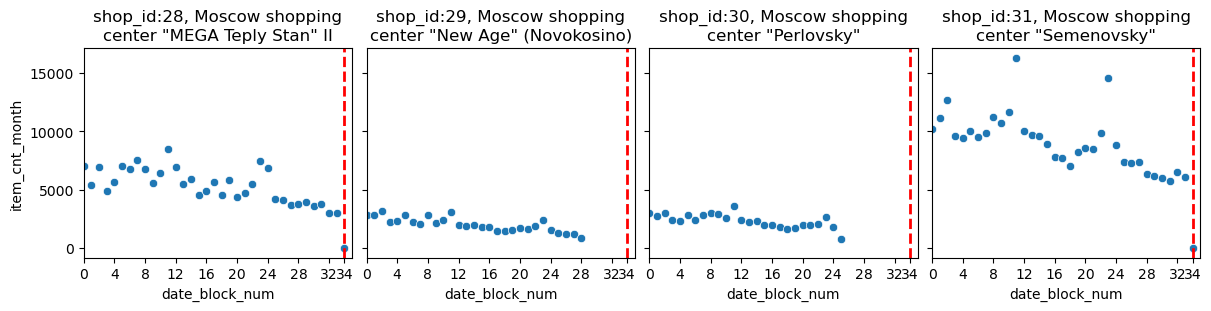

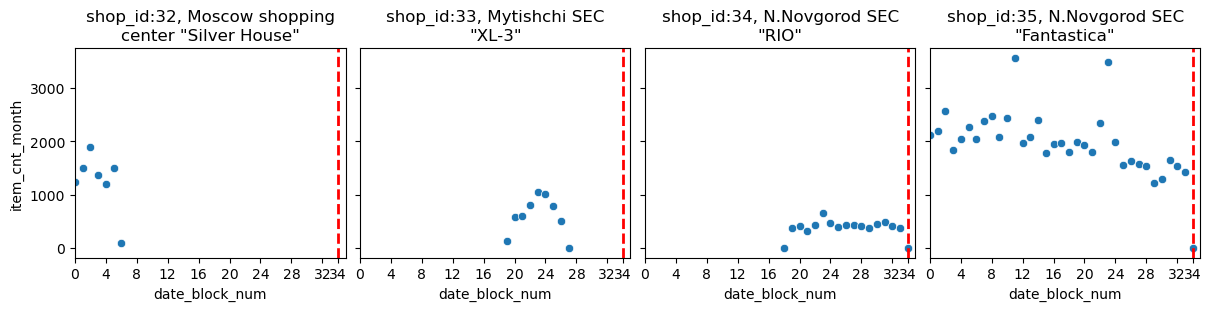

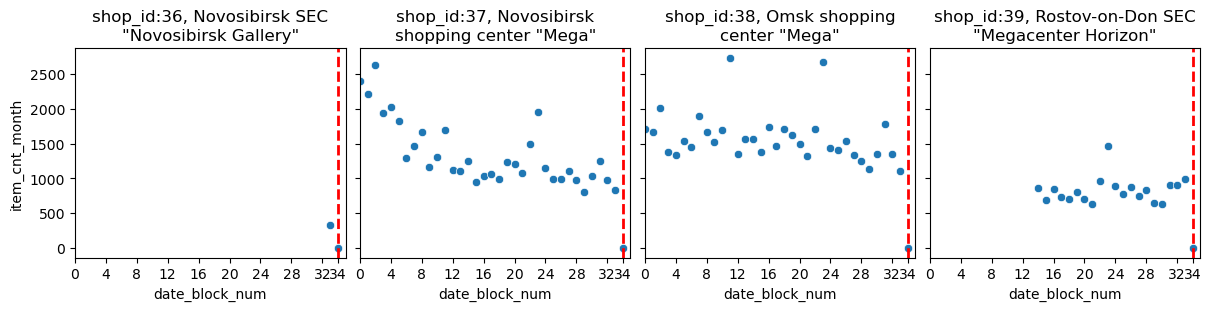

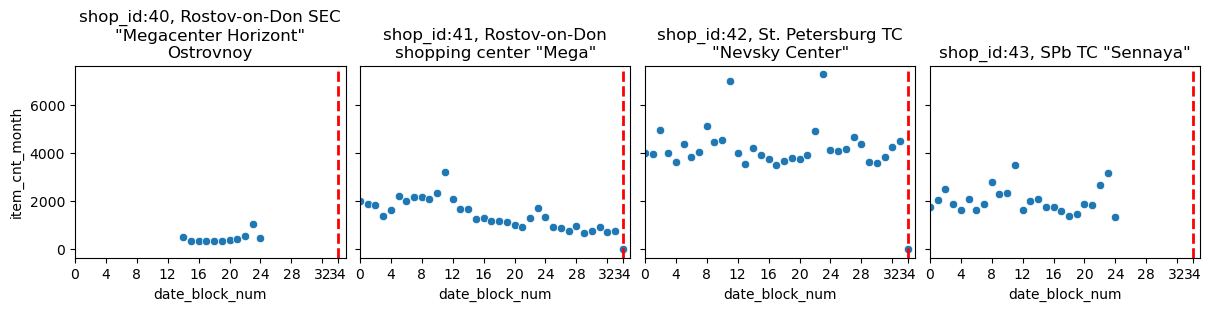

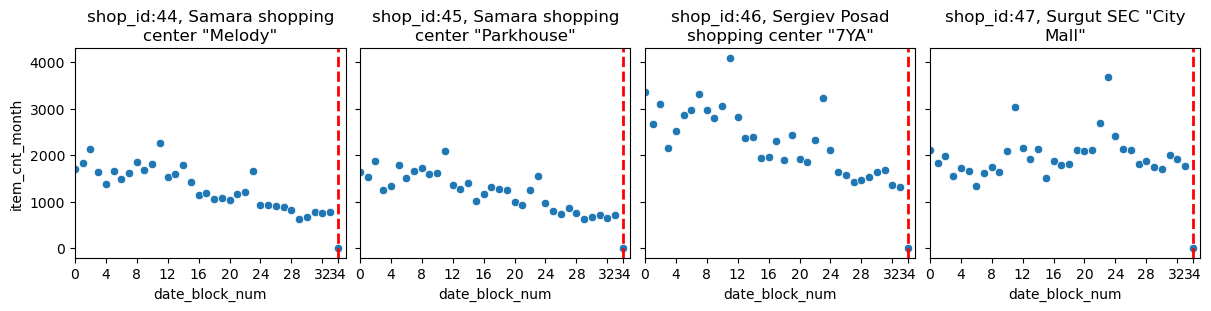

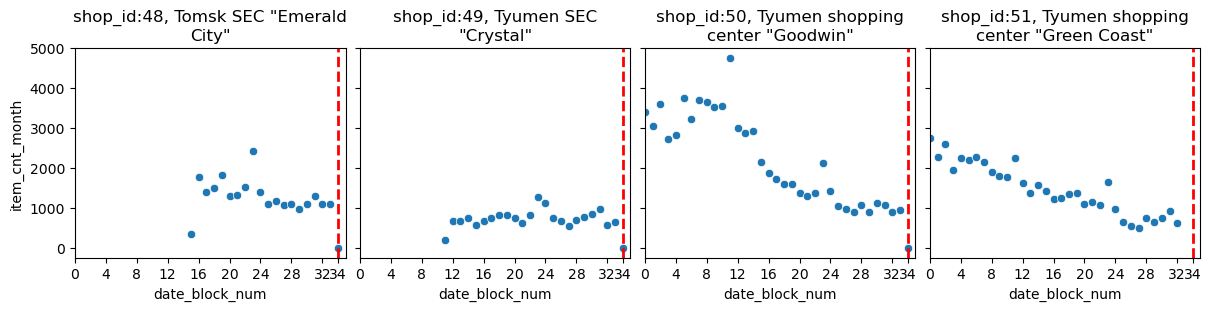

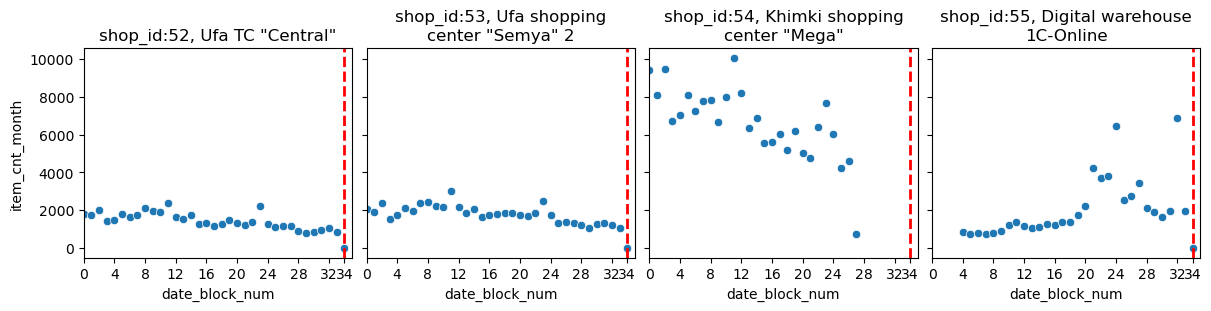

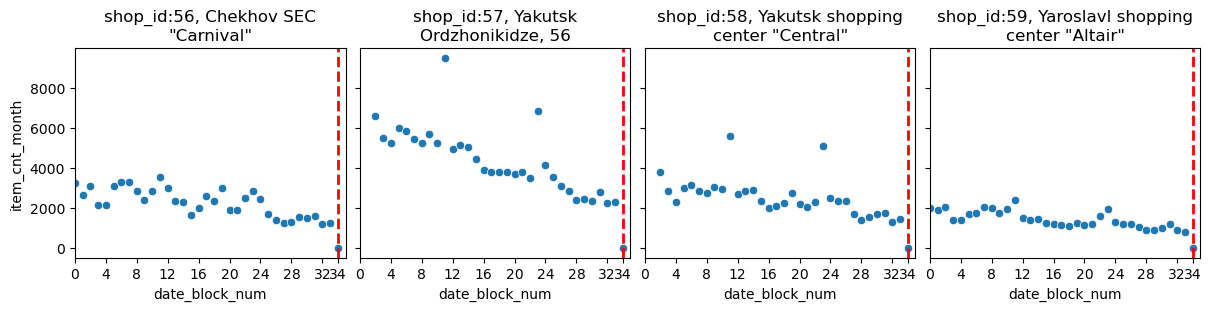

In [167]:
#plot monthly sales for each shop

df_groupby = df_all.groupby('shop_id')
shop_name_list=df_shops['shop_name'].tolist()


x_ticks=[4*x for x in range(9)] + [34]
columns_in_a_row=4    
max_length = 60
i=0
while i < max_length:
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3), sharey=True, sharex=True)
    for j in range(columns_in_a_row):
            if i+j < max_length:
                df = df_groupby.get_group(i+j).groupby('date_block_num').agg({'item_cnt_month':'sum'})
                sns.scatterplot(data=df,x='date_block_num' ,y='item_cnt_month', ax=axs[j])
                
                #set x-axis
                axs[j].set_xticks(x_ticks)
                axs[j].set_xlim([0, 35])
            
                #plot month 34, which is the month we need to predict
                axs[j].axvline(34, linewidth=2, ls='dashed', c='red')
            
                #print the shope name
                axs[j].set_title("\n".join(wrap(f'shop_id:{i+j}, {shop_name_list[i+j]}', 30)))
           
    i +=columns_in_a_row
    
plt.show()

**Observations**
- many shops seemed closed after running some months
- stable monthly sales in some shops 
- downtrend monthly sales in many shops
- uptrend monthly sales in 2 online shops
- not all shops in test data
- shop_id: 0 and 57 seem the same shop
- shop_id: 1 and 58 seem the same shop
- shop_id: 10 and 11 seem the same shop
- we will merge those shop together later

#### merge shop_id 0 and 57,  1 and 58, 10 and 11

In [168]:
df_all.loc[df_all.shop_id == 0, 'shop_id'] = 57
df_all.loc[df_all.shop_id == 1, 'shop_id'] = 58
df_all.loc[df_all.shop_id == 11, 'shop_id'] = 10

### Plot monthly sales for each category

ploting monthly sales for each category


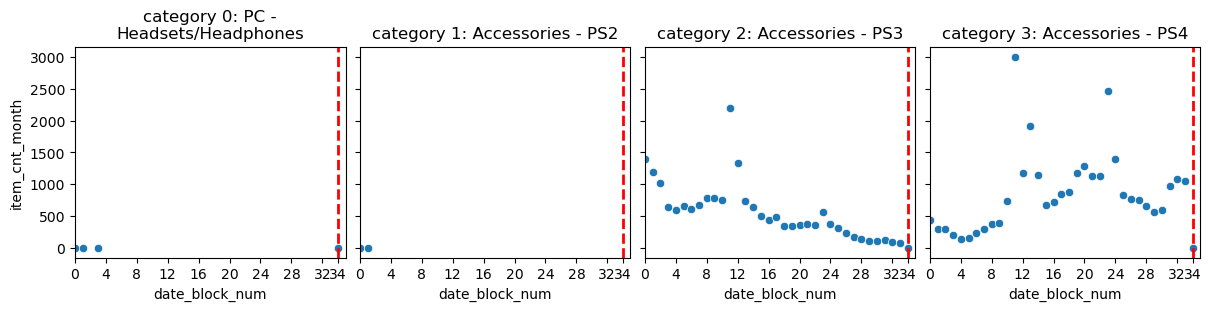

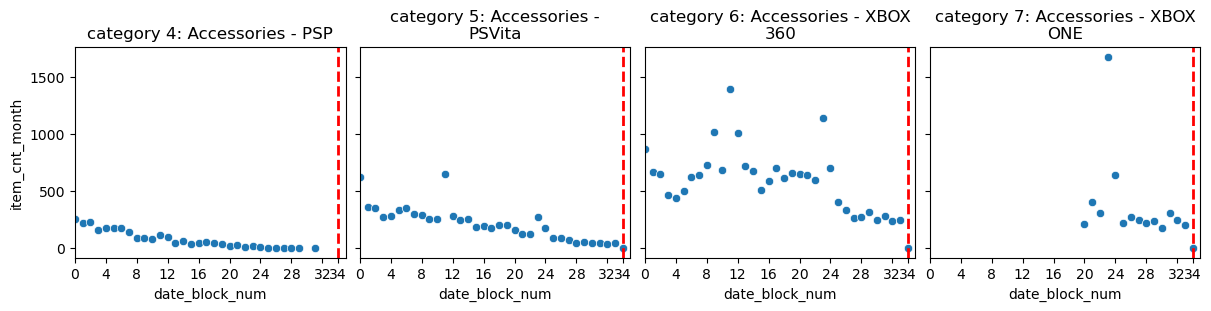

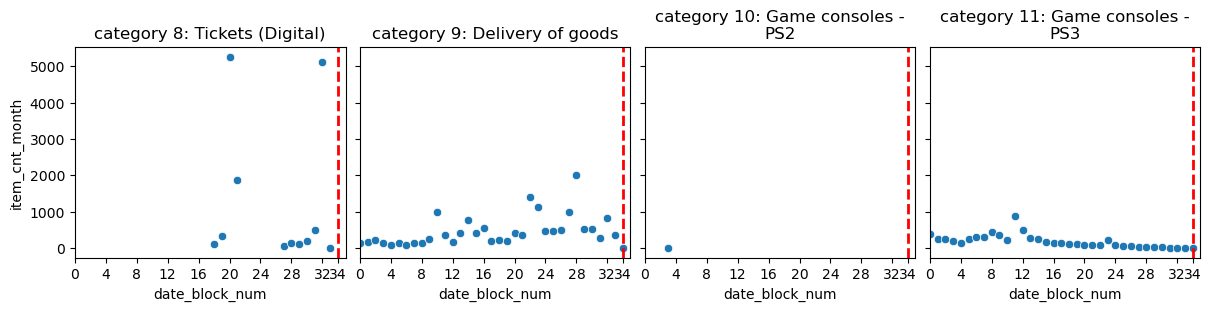

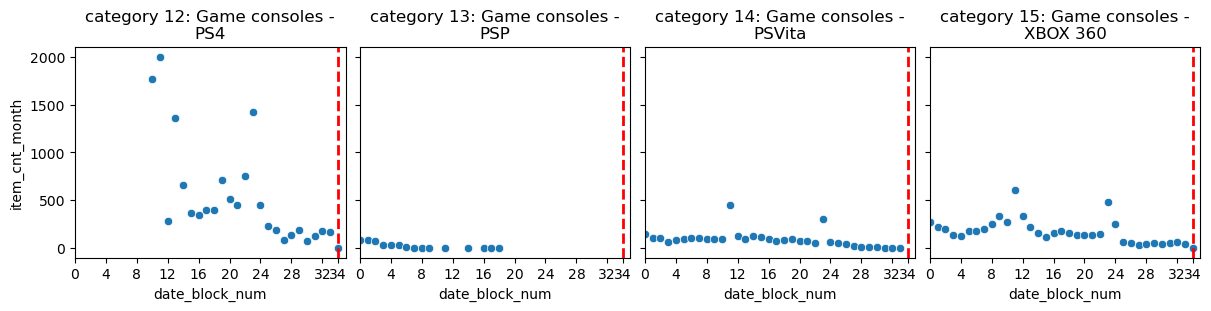

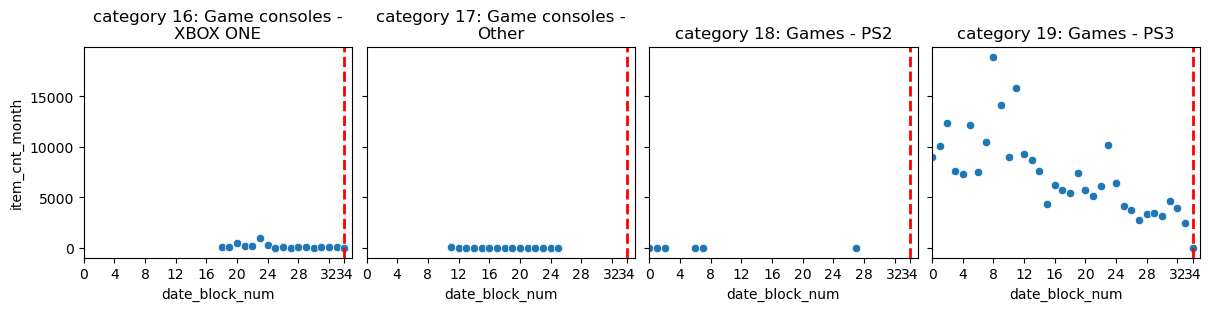

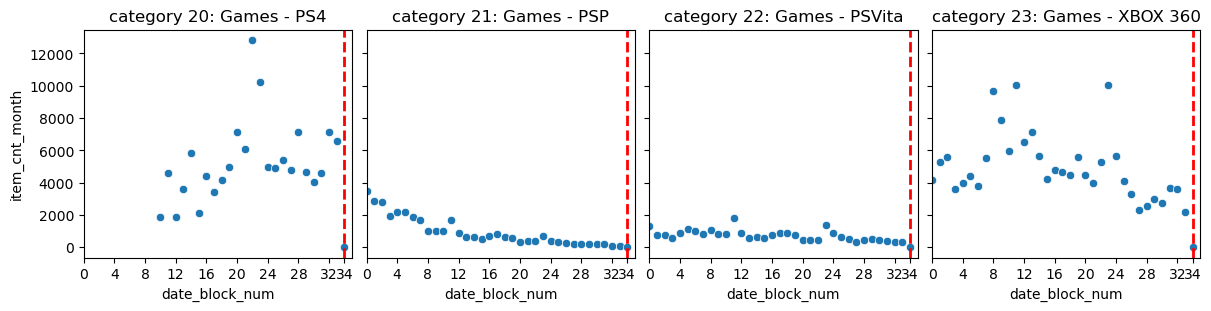

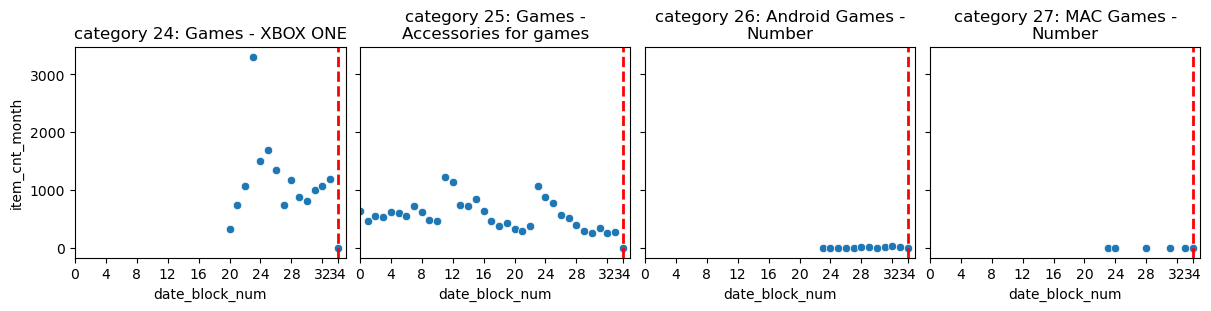

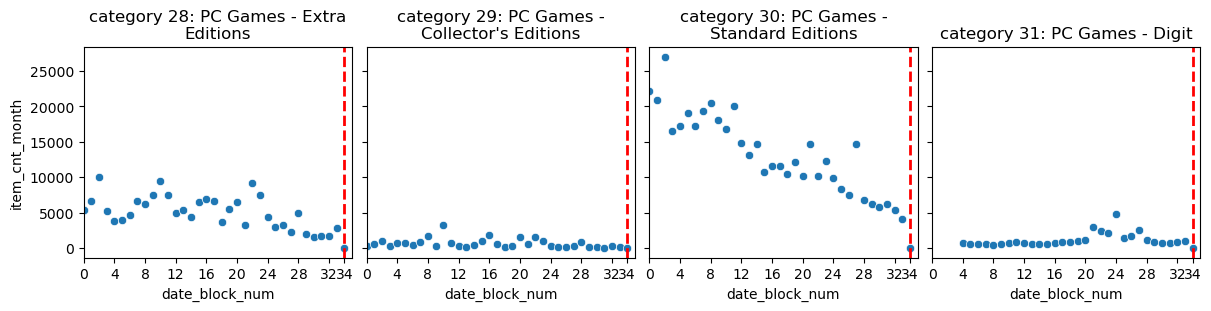

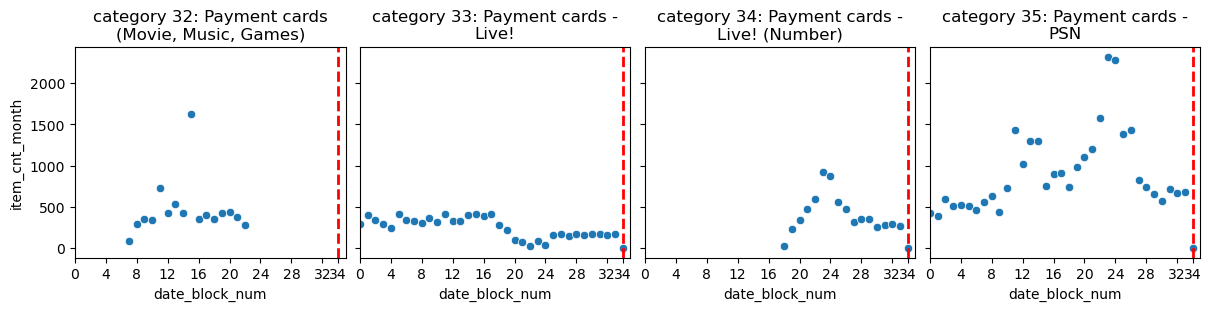

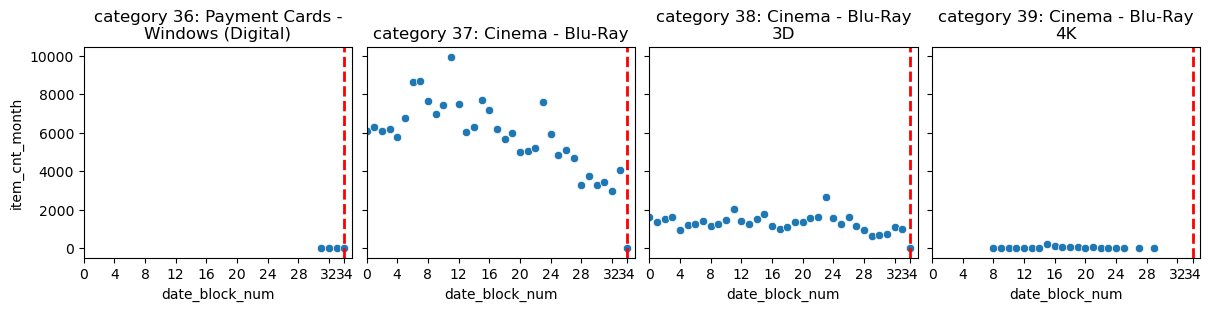

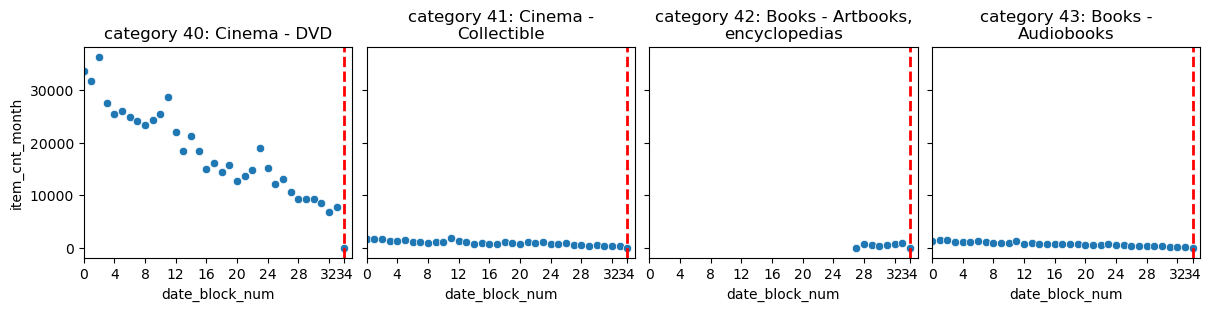

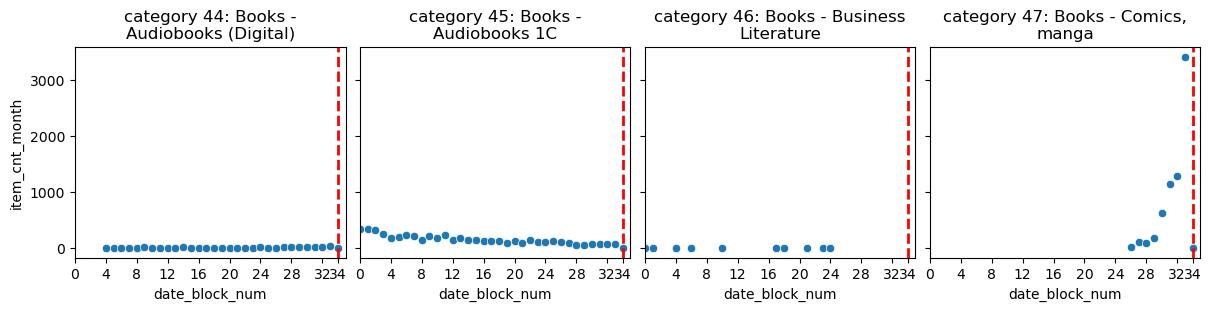

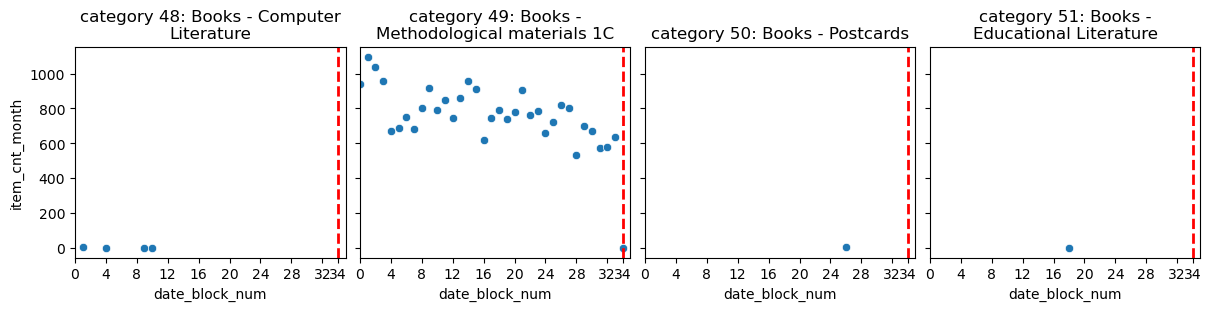

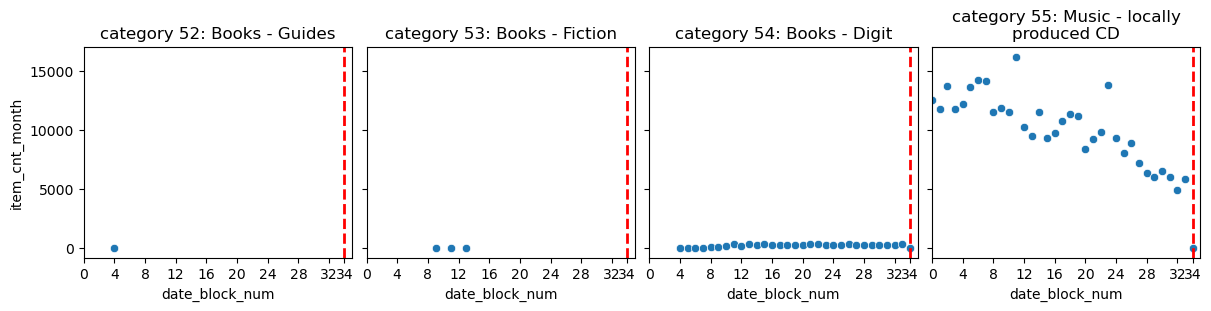

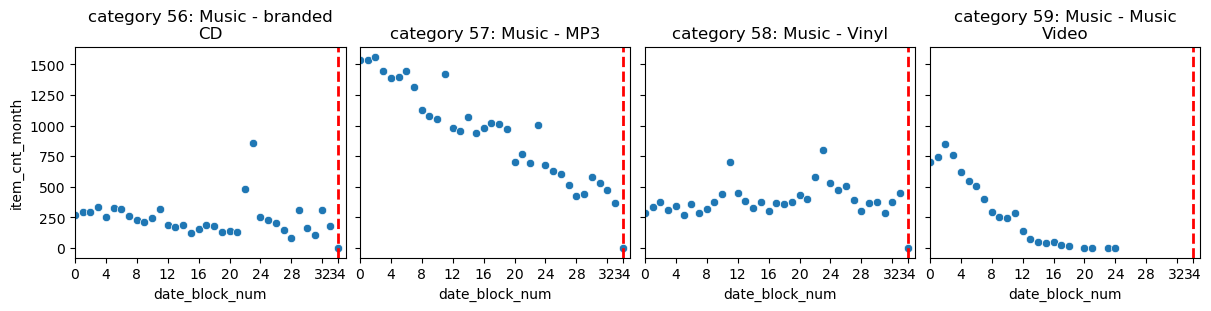

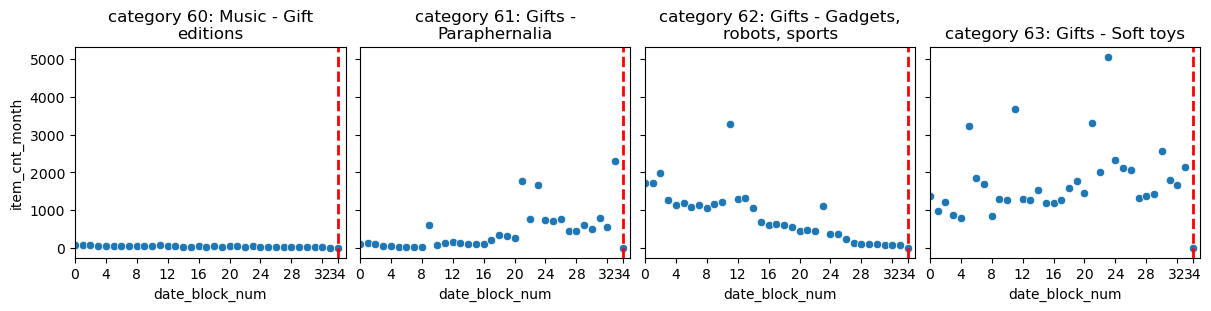

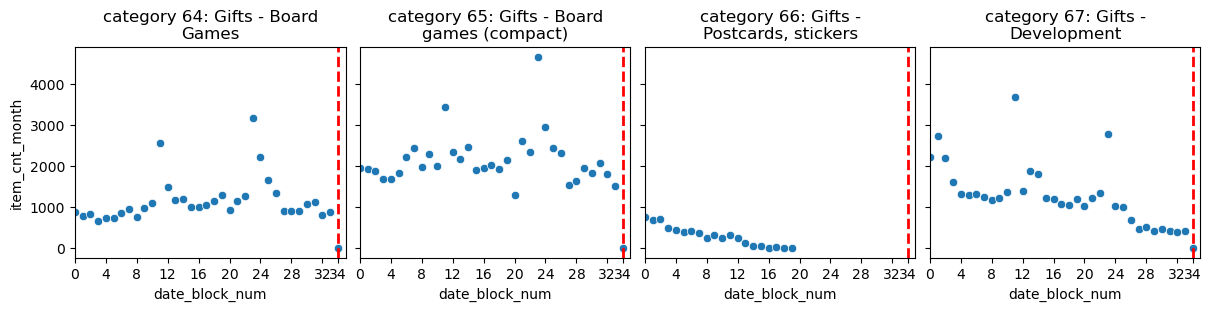

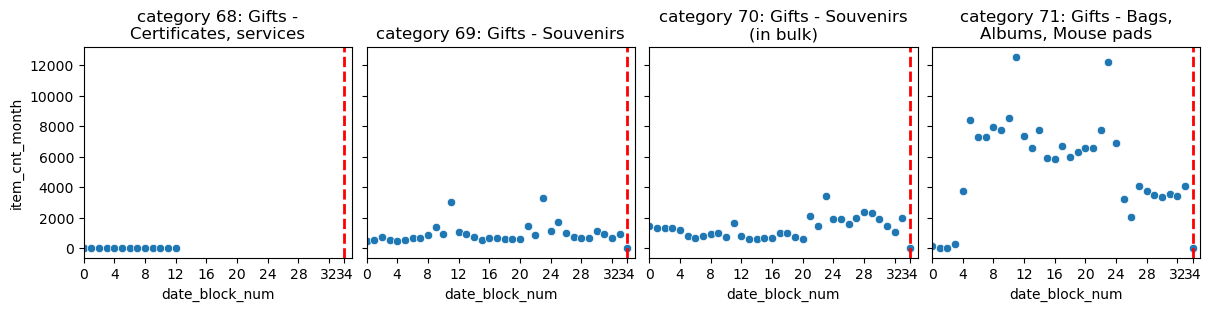

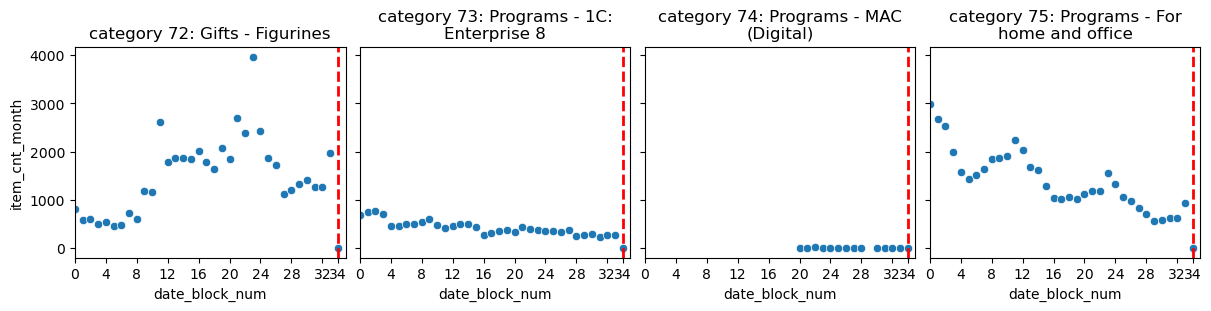

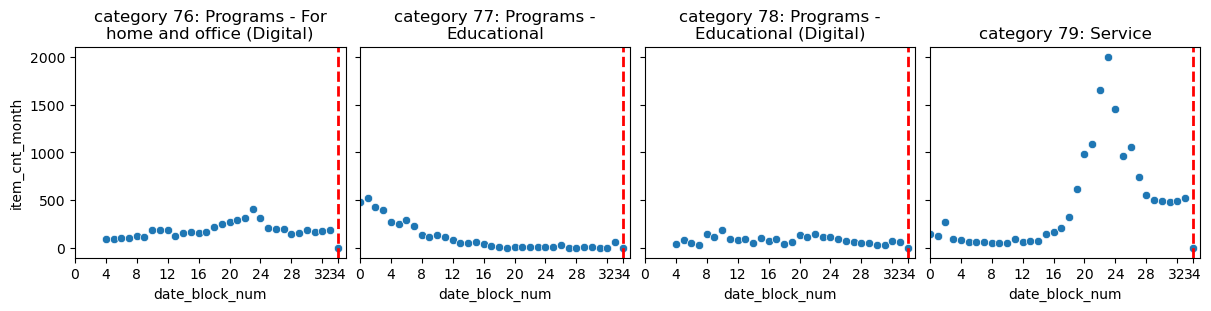

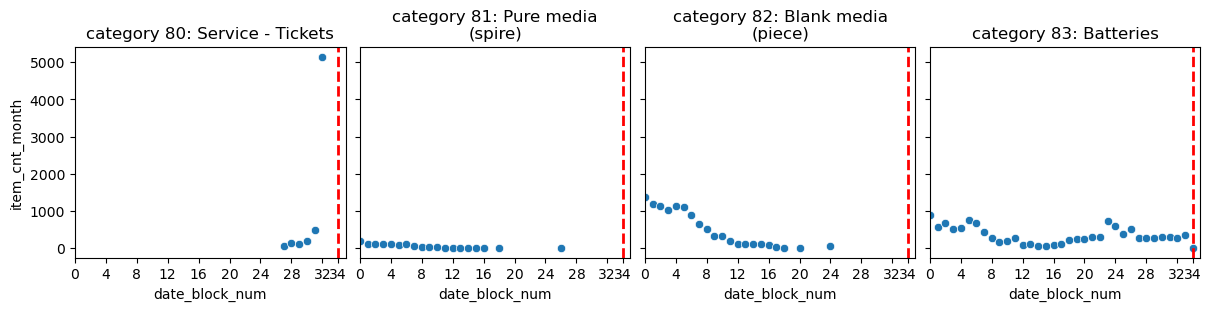

In [169]:
#plot monthly sales for each category

print('ploting monthly sales for each category')
df_groupby = df_all.groupby('item_category_id')
cat_name_list=df_cat['item_category_name'].tolist()


x_ticks=[4*x for x in range(9)] + [34]
columns_in_a_row=4    
max_length = 84
i=0
while i < max_length:
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3), sharey=True, sharex=True)
    for j in range(columns_in_a_row):
            if i+j < max_length:
                df = df_groupby.get_group(i+j).groupby('date_block_num').agg({'item_cnt_month':'sum'})
                sns.scatterplot(data=df,x='date_block_num' ,y='item_cnt_month', ax=axs[j])
                
                #set x-axis
                axs[j].set_xticks(x_ticks)
                axs[j].set_xlim([0, 35])
               
                #plot month 34, which is the month we need to predict
                axs[j].axvline(34, linewidth=2, ls='dashed', c='red')
                
                #print the shope name
                axs[j].set_title("\n".join(wrap(f'category {i+j}: {cat_name_list[i+j]}', 30)))
           
    i +=columns_in_a_row
    
plt.show()

**Observations**
- Different trends occur in different categories.
- Seasonality are obvious in some categories
- Many categories are no longer for sale, which will be not considered in modelling
- not every category was available in every shop
- the sales of each category varid dramatically

### EDA the shops and categories shown in df_test

In [172]:
print("Number of shops: ", len(test_shop_list))
print(test_shop_list)

Number of shops:  42
[2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59]


In [173]:
print("Number of categories: ", len(test_cat_list))
print(test_cat_list)

Number of categories:  62
[0, 2, 3, 5, 6, 7, 9, 11, 12, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 47, 49, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83]


In [174]:
#action
df_all_filtered = df_all[df_all['shop_id'].isin(test_shop_list) & 
                         df_all['item_category_id'].isin(test_cat_list) &
                         df_all['item_id'].isin(test_item_list)
                        ]
df_all_filtered.sort_values(by=['date_block_num','shop_id','item_category_id'], inplace=True)

C:\Users\olive\AppData\Local\Temp\ipykernel_4532\1454098964.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_filtered.sort_values(by=['date_block_num','shop_id','item_category_id'], inplace=True)


In [ ]:
#plot monthly sales for each shops shown in df_test
print('ploting monthly sales for each shops shown in df_test')
df_groupby = df_all_filtered 
shop_name_list=df_shops.loc[df_shops['shop_id'].isin(test_shop_list),'shop_name'].tolist()


x_ticks=[4*x for x in range(9)] + [34]
columns_in_a_row=4    
max_length = len(test_shop_list)
i=0
while i < max_length:
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3), sharey=True, sharex=True)
    for j in range(columns_in_a_row):
            if i+j < max_length:
                df = df_groupby[df_all_filtered['shop_id']==test_shop_list[i+j]]
                df = df.groupby('date_block_num').agg({'item_cnt_month':'sum'})
                sns.scatterplot(data=df,x='date_block_num' ,y='item_cnt_month', ax=axs[j])
                
                #set x-axis
                axs[j].set_xticks(x_ticks)
                axs[j].set_xlim([0, 35])
                
                #plot month 34, which is the month we need to predict
                axs[j].axvline(34, linewidth=2, ls='dashed', c='red')
               
                #print the shope name
                axs[j].set_title("\n".join(wrap(f'shop_id:{test_shop_list[i+j]}, {shop_name_list[i+j]}', 30)))
           
    i +=columns_in_a_row
    
plt.show()

**observations**
- all shops shown in test data seems to be the ones still operating

In [ ]:
#plot monthly sales for each category

print('ploting monthly sales for each category shown in df_test')
df_groupby = df_all_filtered 
#shop_name_list=df_shops.loc[df_shops['shop_id'].isin(test_shop_list),'shop_name'].tolist()


x_ticks=[4*x for x in range(9)] + [34]
columns_in_a_row=4    
max_length = len(test_cat_list)
i=0
while i < max_length:
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3), sharey=True, sharex=True)
    for j in range(columns_in_a_row):
            if i+j < max_length:
                df = df_groupby[df_all_filtered['item_category_id']==test_cat_list[i+j]]
                df = df.groupby('date_block_num').agg({'item_cnt_month':'sum'})
                sns.scatterplot(data=df,x='date_block_num' ,y='item_cnt_month', ax=axs[j])
                
                #set x-axis
                axs[j].set_xticks(x_ticks)
                axs[j].set_xlim([0, 35])
                
                #plot month 34, which is the month we need to predict
                axs[j].axvline(34, linewidth=2, ls='dashed', c='red')
               
                #print the shope name
                axs[j].set_title("\n".join(wrap(f'category {i+j}: {cat_name_list[i+j]}', 30)))
           
           
    i +=columns_in_a_row
    
plt.show()

In [ ]:
#plot category sales for each shops shown in df_test

df_groupby = df_all_filtered 
shop_name_list=df_shops.loc[df_shops['shop_id'].isin(test_shop_list),'shop_name'].tolist()



x_ticks=[5*x for x in range(len(cat_name_list)//5+2)]
columns_in_a_row=4    
max_length = len(test_shop_list)
i=0
while i < max_length:
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3), sharey=True, sharex=True)
    for j in range(columns_in_a_row):
            if i+j < max_length:
                df = df_groupby[df_all_filtered['shop_id']==test_shop_list[i+j]]
                df = df.groupby('item_category_id').agg({'item_cnt_month':'sum'})
                sns.scatterplot(data=df,x='item_category_id' ,y='item_cnt_month', ax=axs[j])
                
                #set x-axis
                axs[j].set_xticks(x_ticks)
                axs[j].set_xlim([0, len(cat_name_list)+1])
               
                #print the shope name
                axs[j].set_title("\n".join(wrap(f'shop_id:{test_shop_list[i+j]}, {shop_name_list[i+j]}', 30)))
           
    i +=columns_in_a_row
    
plt.show()

**Observations**
- Most categories have low transaction
- Sales of different categories at different shops varied dramatically

# Pickle

In [189]:

#save neccessary object to pickle_dict, which will be pickled in other notebook for feature engineering and modeling
#
pickle_dict1 = dict()
pickle_dict1['df_all']=df_all_filtered   #concat df_train_m and df_test
pickle_dict1['df_train']=df_train
pickle_dict1['df_test']=df_test
pickle_dict1['df_items']=df_items
pickle_dict1['df_shops']=df_shops
pickle_dict1['df_cat']=df_cat
pickle_dict1['new_arrival_item_list'] = new_arrival_item_list


pickle.dump(pickle_dict1, open('../temp/data1.pkl', 'wb'))



# Create datagrid for better modelling
- For every month we create a grid from all shops/items combinations from that month

## import data from pickle file

In [190]:
#read pickle_dict, which store everything
pickle_dict1 = pickle.load(open('../temp/data1.pkl', 'rb'))
df_all = pickle_dict1['df_all']   #concat df_train_m and df_test
df_train = pickle_dict1['df_train']
df_test = pickle_dict1['df_test']
df_items = pickle_dict1['df_items']
df_shops = pickle_dict1['df_shops']
df_cat = pickle_dict1['df_cat']
new_arrival_item_list = pickle_dict1['new_arrival_item_list']

### create plain grid and merge df_all --> df_grid2

In [191]:
#https://www.kaggle.com/code/szhou42/predict-future-sales-top-11-solution/notebook
# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in df_all['date_block_num'].unique():
    cur_shops = df_all[df_all['date_block_num']==block_num]['shop_id'].unique()
    cur_items = df_all[df_all['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
index_cols = ['shop_id', 'item_id', 'date_block_num']

#plain grid dataframe
df_grid1 = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)


In [192]:

#merge df_all to df_grid1
df_grid2 = pd.merge(df_grid1,df_all,how='left',on=index_cols)

shop_list = df_grid2['shop_id'].unique()
print("how many shops: ", len(shop_list))

item_list = df_grid2['item_id'].unique()
print("how many items: ", len(item_list))

cat_list = df_grid2['item_category_id'].unique()
print("how many categories: ", len(cat_list))

df_grid2.info()

how many shops:  42
how many items:  5100
how many categories:  63
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2953005 entries, 0 to 2953004
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   shop_id           int32  
 1   item_id           int32  
 2   date_block_num    int32  
 3   item_category_id  float64
 4   item_price        float64
 5   item_cnt_month    float64
 6   is_new_arrival    float64
dtypes: float64(4), int32(3)
memory usage: 146.4 MB


### df_grid2: handle null value, drop columns --> df_grid3
- clip 'item_cnt_month' to [0, 20]

In [193]:
#handle null value
df_grid2['item_cnt_month'] = df_grid2['item_cnt_month'].fillna(0).astype(int)
df_grid2['item_price'] = df_grid2['item_price'].fillna(0)
df_grid2['is_new_arrival'] = np.where(df_grid2['item_id'].isin(new_arrival_item_list), 1, 0) 


#clip 'item_cnt_month' 
df_grid2['item_cnt_month'] = df_grid2['item_cnt_month'].clip(0, 20)

#drop this column
df_grid3=df_grid2.drop(columns=['item_category_id'])


In [194]:

#create new column
df_grid3["month"] = ((df_grid3["date_block_num"]+1)%12).astype(int)
df_grid3['year'] = ((df_grid3["date_block_num"]+1)//12 + 2013).astype(int)
df_grid3['year'] = np.where(df_grid3['month']==0, df_grid3['year']-1,df_grid3['year'] )
df_grid3['month'] = np.where(df_grid3['month']==0, 12,df_grid3['month'] )

#create 'year_month'
df_grid3['year_month'] = df_grid3.apply(lambda x:f"{int(x.year)}-{int(x.month)}",axis=1).apply(pd.to_datetime)
df_grid3['year_month'].unique()


array(['2013-01-01T00:00:00.000000000', '2013-02-01T00:00:00.000000000',
       '2013-03-01T00:00:00.000000000', '2013-04-01T00:00:00.000000000',
       '2013-05-01T00:00:00.000000000', '2013-06-01T00:00:00.000000000',
       '2013-07-01T00:00:00.000000000', '2013-08-01T00:00:00.000000000',
       '2013-09-01T00:00:00.000000000', '2013-10-01T00:00:00.000000000',
       '2013-11-01T00:00:00.000000000', '2013-12-01T00:00:00.000000000',
       '2014-01-01T00:00:00.000000000', '2014-02-01T00:00:00.000000000',
       '2014-03-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
       '2014-05-01T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
       '2014-07-01T00:00:00.000000000', '2014-08-01T00:00:00.000000000',
       '2014-09-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
       '2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-03-01T00:00:00.000000000', '2015-04-01

### df_grid3: add 'item_category_id'  =>df_basegrid (final grid where we will do feature engineering and modelling)

In [195]:
df_basegrid = pd.merge(df_grid3,df_items[['item_id','item_category_id']],how='left',on='item_id')


# pickle

In [196]:
#save neccessary object to pickle_dict, which will be pickled in other notebook for feature engineering and modeling
#
pickle_dict2 = dict()
pickle_dict2['df_basegrid']=df_basegrid   #concat df_train_m and df_test
pickle.dump(pickle_dict2, open('../temp/data2.pkl', 'wb'))



In [218]:
df_basegrid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2953005 entries, 0 to 2953004
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   shop_id           int32         
 1   item_id           int32         
 2   date_block_num    int32         
 3   item_price        float64       
 4   item_cnt_month    int32         
 5   is_new_arrival    int32         
 6   month             int32         
 7   year              int32         
 8   year_month        datetime64[ns]
 9   item_category_id  int64         
dtypes: datetime64[ns](1), float64(1), int32(7), int64(1)
memory usage: 169.0 MB
